In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1.5)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms import CompositeTransform, RandomPermutation
from nflows.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from nflows.transforms.base import Transform
from nflows.transforms import Sigmoid, InverseTransform

#print('Python', sys.version)

In [2]:
class dalitz_dataset(Dataset):
    """
    Creates Dalitz dataset following PyTorch dataloader conventions.
    """

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

In [3]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features,
                 hidden = 64, layers = 2, output_scale = 0.30):
        super().__init__()
        # Build a simple feed-forward network.
        feats = [nn.Linear(in_features, hidden), nn.SiLU()]
        for _ in range(layers - 1):
            feats += [nn.Linear(hidden, hidden), nn.SiLU()]
        self.backbone = nn.Sequential(*feats)
        self.head = nn.Linear(hidden, out_features)

        # Start logits near zero so spline softmax is well-behaved.
        nn.init.zeros_(self.head.weight)
        nn.init.zeros_(self.head.bias)

        self.output_scale = output_scale

    def forward(self, x, context = None):
        h = self.backbone(x)
        return self.head(h) * self.output_scale

In [4]:
def conjure_flow(on_unit_box = True, num_flows = 8, hidden_features = 64, num_bins = 8):
    dim = 2
    transforms = []
    if on_unit_box:
        # Use logit pre-transform to map (0,1) to R.
        transforms.append(InverseTransform(Sigmoid()))

    masks = [torch.tensor([1,0], dtype=torch.bool), torch.tensor([0,1], dtype = torch.bool)]
    for i in range(num_flows):
        mask = masks[i % 2]
        def conditioner(in_features, out_features, _hidden = hidden_features):
            return MLP(in_features, out_features, hidden = _hidden, layers = 2)
        transforms.append(
            PiecewiseRationalQuadraticCouplingTransform(
                mask                          = mask,
                transform_net_create_fn       = conditioner,
                num_bins                      = num_bins,
                tails                         = "linear",
                tail_bound                    = 5.0,
                apply_unconditional_transform = False,
            )
        )
        transforms.append(RandomPermutation(features = dim))

    transform = CompositeTransform(transforms)
    base = StandardNormal(shape = [dim])
    return Flow(transform, base)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [6]:
def train_flow(flow, train_loader, lr = 1e-3, epochs = 5,
    device = "cuda" if torch.cuda.is_available() else "cpu"):
    
    flow.to(device)
    # Initialize optimizer.
    opt = torch.optim.Adam(flow.parameters(), lr=lr)

    # Initialize learning rate scheduler.
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.9, patience=3, min_lr=1e-6)

    # Train!
    for epoch in tqdm(range(1, epochs + 1), ncols = 50):
        flow.train()
        running = 0.0
        for xb in train_loader:
            xb = xb.to(device)
            # Negative log-likelihood
            loss = -flow.log_prob(xb).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)

        # Average negative log-likelihood per data point.
        nll = running / len(train_loader.dataset)

        # Update scheduler.
        scheduler.step(loss)

        # Output training analytics.
        print(f"[{epoch:03d}] Loss: {nll:.4f}, lr: {opt.param_groups[0]['lr']:.6f}")

    return flow

In [7]:
# Load in Dalitz dataset
mp_thetap = np.load('../data/D_Kspipi_SDP_1e7.npy')

In [8]:
# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.8)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert into torch objects
mp_thetap_train = torch.Tensor(mp_thetap_train)
#mp_thetap_val   = torch.Tensor(mp_thetap_val)

trainset = dalitz_dataset(mp_thetap_train)
#valset   = dalitz_dataset(mp_thetap_val)

batch_size = 50000

train_dataloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
#val_dataloader = DataLoader(valset, batch_size = batch_size, shuffle = True)

# Initialize hyperparameters
epochs = 100
learning_rate = 0.009
min_learning_rate = 1e-6
n_blocks = 12
n_bins = 25
hidden_features = 128

# Define the model
flow = conjure_flow(num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)

# Print the total number of parameters
total_params = sum(p.numel() for p in flow.parameters())
print(f"Total parameters: {total_params}")
# Print total number of trainable parameters
trainable_params = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(f"Differentiable parameters: {trainable_params}")

flow = train_flow(flow, train_dataloader, lr = learning_rate, epochs = epochs)

print("Done!")

Training set size:  (2000000, 2) Validation set size:  (8000000, 2)
Total parameters: 315768
Differentiable parameters: 315768


  0%|                     | 0/100 [00:00<?, ?it/s]/home/menzo/miniconda3/envs/ml_gamma_extraction/lib/python3.13/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
  1%|          | 1/100 [04:49<7:58:03, 289.73s/it]

[001] Loss: -0.4467, lr: 0.009000


  2%|▏         | 2/100 [09:39<7:53:34, 289.94s/it]

[002] Loss: -1.0755, lr: 0.009000


  3%|▎         | 3/100 [14:32<7:50:47, 291.21s/it]

[003] Loss: -1.0936, lr: 0.009000


  4%|▍         | 4/100 [19:15<7:40:48, 288.00s/it]

[004] Loss: -1.1034, lr: 0.009000


  5%|▌         | 5/100 [23:57<7:32:28, 285.78s/it]

[005] Loss: -1.1047, lr: 0.009000


  6%|▌         | 6/100 [28:39<7:25:56, 284.64s/it]

[006] Loss: -1.1081, lr: 0.009000


  7%|▋         | 7/100 [33:22<7:20:01, 283.88s/it]

[007] Loss: -1.1096, lr: 0.009000


  8%|▊         | 8/100 [38:07<7:15:54, 284.29s/it]

[008] Loss: -1.1124, lr: 0.009000


  9%|▉         | 9/100 [42:51<7:11:14, 284.34s/it]

[009] Loss: -1.1139, lr: 0.009000


 10%|▉        | 10/100 [47:33<7:05:25, 283.61s/it]

[010] Loss: -1.1091, lr: 0.009000


 11%|▉        | 11/100 [52:15<6:59:54, 283.08s/it]

[011] Loss: -1.1133, lr: 0.008100


 12%|█        | 12/100 [56:58<6:55:05, 283.01s/it]

[012] Loss: -1.1151, lr: 0.008100


 13%|▉      | 13/100 [1:01:41<6:50:26, 283.06s/it]

[013] Loss: -1.1165, lr: 0.008100


 14%|▉      | 14/100 [1:06:21<6:44:27, 282.18s/it]

[014] Loss: -1.1135, lr: 0.008100


 15%|█      | 15/100 [1:11:06<6:40:59, 283.06s/it]

[015] Loss: -1.1148, lr: 0.008100


 16%|█      | 16/100 [1:15:49<6:36:14, 283.03s/it]

[016] Loss: -1.1140, lr: 0.008100


 17%|█▏     | 17/100 [1:20:36<6:33:04, 284.15s/it]

[017] Loss: -1.1174, lr: 0.007290


 18%|█▎     | 18/100 [1:25:27<6:30:57, 286.06s/it]

[018] Loss: -1.1188, lr: 0.007290


 19%|█▎     | 19/100 [1:30:16<6:27:37, 287.13s/it]

[019] Loss: -1.1182, lr: 0.007290


 20%|█▍     | 20/100 [1:35:08<6:24:49, 288.62s/it]

[020] Loss: -1.1185, lr: 0.007290


 21%|█▍     | 21/100 [1:39:50<6:17:05, 286.39s/it]

[021] Loss: -1.1181, lr: 0.007290


 22%|█▌     | 22/100 [1:44:36<6:12:18, 286.39s/it]

[022] Loss: -1.1187, lr: 0.007290


 23%|█▌     | 23/100 [1:49:20<6:06:39, 285.71s/it]

[023] Loss: -1.1167, lr: 0.007290


 24%|█▋     | 24/100 [1:53:58<5:59:04, 283.47s/it]

[024] Loss: -1.1174, lr: 0.007290


 25%|█▊     | 25/100 [1:58:38<5:53:02, 282.44s/it]

[025] Loss: -1.1175, lr: 0.007290


 26%|█▊     | 26/100 [2:03:18<5:47:21, 281.64s/it]

[026] Loss: -1.1189, lr: 0.006561


 27%|█▉     | 27/100 [2:07:58<5:41:57, 281.06s/it]

[027] Loss: -1.1196, lr: 0.006561


 28%|█▉     | 28/100 [2:12:38<5:36:49, 280.69s/it]

[028] Loss: -1.1190, lr: 0.006561


 29%|██     | 29/100 [2:17:21<5:33:08, 281.53s/it]

[029] Loss: -1.1207, lr: 0.006561


 30%|██     | 30/100 [2:22:02<5:28:16, 281.38s/it]

[030] Loss: -1.1177, lr: 0.006561


 31%|██▏    | 31/100 [2:26:46<5:24:16, 281.98s/it]

[031] Loss: -1.1202, lr: 0.006561


 32%|██▏    | 32/100 [2:31:32<5:21:07, 283.34s/it]

[032] Loss: -1.1199, lr: 0.006561


 33%|██▎    | 33/100 [2:36:19<5:17:25, 284.26s/it]

[033] Loss: -1.1204, lr: 0.006561


 34%|██▍    | 34/100 [2:40:58<5:11:06, 282.82s/it]

[034] Loss: -1.1207, lr: 0.005905


 35%|██▍    | 35/100 [2:45:40<5:06:00, 282.47s/it]

[035] Loss: -1.1202, lr: 0.005905


 36%|██▌    | 36/100 [2:50:23<5:01:32, 282.69s/it]

[036] Loss: -1.1194, lr: 0.005905


 37%|██▌    | 37/100 [2:55:03<4:55:55, 281.84s/it]

[037] Loss: -1.1210, lr: 0.005905


 38%|██▋    | 38/100 [2:59:45<4:51:22, 281.97s/it]

[038] Loss: -1.1206, lr: 0.005314


 39%|██▋    | 39/100 [3:04:27<4:46:36, 281.90s/it]

[039] Loss: -1.1216, lr: 0.005314


 40%|██▊    | 40/100 [3:09:10<4:42:20, 282.34s/it]

[040] Loss: -1.1216, lr: 0.005314


 41%|██▊    | 41/100 [3:13:50<4:36:51, 281.54s/it]

[041] Loss: -1.1213, lr: 0.005314


 42%|██▉    | 42/100 [3:18:32<4:32:27, 281.85s/it]

[042] Loss: -1.1214, lr: 0.004783


 43%|███    | 43/100 [3:23:15<4:28:03, 282.17s/it]

[043] Loss: -1.1206, lr: 0.004783


 44%|███    | 44/100 [3:27:56<4:22:57, 281.75s/it]

[044] Loss: -1.1217, lr: 0.004783


 45%|███▏   | 45/100 [3:32:35<4:17:38, 281.07s/it]

[045] Loss: -1.1216, lr: 0.004783


 46%|███▏   | 46/100 [3:37:16<4:12:56, 281.05s/it]

[046] Loss: -1.1214, lr: 0.004305


 47%|███▎   | 47/100 [3:41:59<4:08:38, 281.48s/it]

[047] Loss: -1.1232, lr: 0.004305


 48%|███▎   | 48/100 [3:46:42<4:04:27, 282.07s/it]

[048] Loss: -1.1226, lr: 0.004305


 49%|███▍   | 49/100 [3:51:24<3:59:36, 281.90s/it]

[049] Loss: -1.1228, lr: 0.004305


 50%|███▌   | 50/100 [3:56:02<3:53:58, 280.77s/it]

[050] Loss: -1.1225, lr: 0.003874


 51%|███▌   | 51/100 [4:00:44<3:49:36, 281.16s/it]

[051] Loss: -1.1228, lr: 0.003874


 52%|███▋   | 52/100 [4:05:26<3:45:08, 281.43s/it]

[052] Loss: -1.1220, lr: 0.003874


 53%|███▋   | 53/100 [4:10:08<3:40:38, 281.67s/it]

[053] Loss: -1.1225, lr: 0.003874


 54%|███▊   | 54/100 [4:14:52<3:36:19, 282.17s/it]

[054] Loss: -1.1222, lr: 0.003487


 55%|███▊   | 55/100 [4:19:33<3:31:20, 281.78s/it]

[055] Loss: -1.1225, lr: 0.003487


 56%|███▉   | 56/100 [4:24:13<3:26:21, 281.41s/it]

[056] Loss: -1.1224, lr: 0.003487


 57%|███▉   | 57/100 [4:28:54<3:21:28, 281.14s/it]

[057] Loss: -1.1225, lr: 0.003487


 58%|████   | 58/100 [4:33:34<3:16:31, 280.75s/it]

[058] Loss: -1.1226, lr: 0.003138


 59%|████▏  | 59/100 [4:38:12<3:11:25, 280.14s/it]

[059] Loss: -1.1227, lr: 0.003138


 60%|████▏  | 60/100 [4:42:53<3:06:55, 280.40s/it]

[060] Loss: -1.1234, lr: 0.003138


 61%|████▎  | 61/100 [4:47:30<3:01:31, 279.27s/it]

[061] Loss: -1.1235, lr: 0.003138


 62%|████▎  | 62/100 [4:52:12<2:57:23, 280.10s/it]

[062] Loss: -1.1231, lr: 0.002824


 63%|████▍  | 63/100 [4:56:53<2:52:50, 280.28s/it]

[063] Loss: -1.1236, lr: 0.002824


 64%|████▍  | 64/100 [5:01:33<2:48:10, 280.28s/it]

[064] Loss: -1.1234, lr: 0.002824


 65%|████▌  | 65/100 [5:06:16<2:44:00, 281.14s/it]

[065] Loss: -1.1235, lr: 0.002824


 66%|████▌  | 66/100 [5:10:59<2:39:38, 281.73s/it]

[066] Loss: -1.1232, lr: 0.002542


 67%|████▋  | 67/100 [5:15:43<2:35:15, 282.29s/it]

[067] Loss: -1.1239, lr: 0.002542


 68%|████▊  | 68/100 [5:20:21<2:29:58, 281.21s/it]

[068] Loss: -1.1239, lr: 0.002542


 69%|████▊  | 69/100 [5:25:03<2:25:23, 281.39s/it]

[069] Loss: -1.1239, lr: 0.002542


 70%|████▉  | 70/100 [5:29:45<2:20:46, 281.56s/it]

[070] Loss: -1.1235, lr: 0.002288


 71%|████▉  | 71/100 [5:34:29<2:16:23, 282.18s/it]

[071] Loss: -1.1241, lr: 0.002288


 72%|█████  | 72/100 [5:39:12<2:11:49, 282.48s/it]

[072] Loss: -1.1242, lr: 0.002288


 73%|█████  | 73/100 [5:43:51<2:06:35, 281.31s/it]

[073] Loss: -1.1244, lr: 0.002288


 74%|█████▏ | 74/100 [5:48:33<2:02:00, 281.55s/it]

[074] Loss: -1.1238, lr: 0.002059


 75%|█████▎ | 75/100 [5:53:12<1:57:05, 281.01s/it]

[075] Loss: -1.1244, lr: 0.002059


 76%|█████▎ | 76/100 [5:57:54<1:52:25, 281.08s/it]

[076] Loss: -1.1241, lr: 0.002059


 77%|█████▍ | 77/100 [6:02:36<1:47:53, 281.44s/it]

[077] Loss: -1.1241, lr: 0.002059


 78%|█████▍ | 78/100 [6:07:18<1:43:15, 281.60s/it]

[078] Loss: -1.1245, lr: 0.001853


 79%|█████▌ | 79/100 [6:12:01<1:38:40, 281.91s/it]

[079] Loss: -1.1242, lr: 0.001853


 80%|█████▌ | 80/100 [6:16:44<1:34:08, 282.41s/it]

[080] Loss: -1.1246, lr: 0.001853


 81%|█████▋ | 81/100 [6:21:22<1:28:57, 280.90s/it]

[081] Loss: -1.1243, lr: 0.001853


 82%|█████▋ | 82/100 [6:26:04<1:24:25, 281.43s/it]

[082] Loss: -1.1240, lr: 0.001668


 83%|█████▊ | 83/100 [6:30:49<1:20:00, 282.39s/it]

[083] Loss: -1.1245, lr: 0.001668


 84%|█████▉ | 84/100 [6:35:31<1:15:17, 282.36s/it]

[084] Loss: -1.1245, lr: 0.001668


 85%|█████▉ | 85/100 [6:40:10<1:10:21, 281.45s/it]

[085] Loss: -1.1244, lr: 0.001668


 86%|██████ | 86/100 [6:44:54<1:05:48, 282.00s/it]

[086] Loss: -1.1243, lr: 0.001501


 87%|██████ | 87/100 [6:49:38<1:01:14, 282.66s/it]

[087] Loss: -1.1244, lr: 0.001501


 88%|███████▉ | 88/100 [6:54:21<56:33, 282.79s/it]

[088] Loss: -1.1245, lr: 0.001501


 89%|████████ | 89/100 [6:59:01<51:41, 281.96s/it]

[089] Loss: -1.1244, lr: 0.001501


 90%|████████ | 90/100 [7:03:44<47:01, 282.13s/it]

[090] Loss: -1.1245, lr: 0.001351


 91%|████████▏| 91/100 [7:08:26<42:21, 282.36s/it]

[091] Loss: -1.1246, lr: 0.001351


 92%|████████▎| 92/100 [7:13:07<37:35, 281.89s/it]

[092] Loss: -1.1246, lr: 0.001351


 93%|████████▎| 93/100 [7:17:49<32:53, 281.90s/it]

[093] Loss: -1.1248, lr: 0.001351


 94%|████████▍| 94/100 [7:22:32<28:12, 282.03s/it]

[094] Loss: -1.1246, lr: 0.001351


 95%|████████▌| 95/100 [7:27:15<23:32, 282.52s/it]

[095] Loss: -1.1248, lr: 0.001351


 96%|████████▋| 96/100 [7:31:59<18:51, 282.90s/it]

[096] Loss: -1.1248, lr: 0.001351


 97%|████████▋| 97/100 [7:36:40<14:06, 282.31s/it]

[097] Loss: -1.1248, lr: 0.001216


 98%|████████▊| 98/100 [7:41:22<09:24, 282.10s/it]

[098] Loss: -1.1249, lr: 0.001216


 99%|████████▉| 99/100 [7:46:02<04:41, 281.49s/it]

[099] Loss: -1.1247, lr: 0.001216


100%|████████| 100/100 [7:50:43<00:00, 282.43s/it]

[100] Loss: -1.1248, lr: 0.001216
Done!


In [30]:
flow = train_flow(flow, train_dataloader, lr = 0.001216, epochs = 30)

  3%|▎          | 1/30 [04:58<2:24:02, 298.03s/it]

[001] Loss: -1.1154, lr: 0.001216


  7%|▋          | 2/30 [09:50<2:17:28, 294.58s/it]

[002] Loss: -1.1250, lr: 0.001216


 10%|█          | 3/30 [14:45<2:12:43, 294.93s/it]

[003] Loss: -1.1248, lr: 0.001216


 13%|█▍         | 4/30 [19:33<2:06:36, 292.18s/it]

[004] Loss: -1.1249, lr: 0.001216


 17%|█▊         | 5/30 [24:18<2:00:41, 289.68s/it]

[005] Loss: -1.1248, lr: 0.001216


 20%|██▏        | 6/30 [29:01<1:54:55, 287.32s/it]

[006] Loss: -1.1246, lr: 0.001216


 23%|██▌        | 7/30 [33:47<1:49:59, 286.96s/it]

[007] Loss: -1.1248, lr: 0.001216


 27%|██▉        | 8/30 [38:31<1:44:50, 285.92s/it]

[008] Loss: -1.1246, lr: 0.001216


 30%|███▎       | 9/30 [43:25<1:40:59, 288.53s/it]

[009] Loss: -1.1245, lr: 0.001094


 33%|███▎      | 10/30 [48:21<1:36:58, 290.93s/it]

[010] Loss: -1.1250, lr: 0.001094


 37%|███▋      | 11/30 [53:19<1:32:43, 292.81s/it]

[011] Loss: -1.1246, lr: 0.001094


 40%|████      | 12/30 [58:05<1:27:17, 290.97s/it]

[012] Loss: -1.1246, lr: 0.001094


 43%|███▍    | 13/30 [1:02:53<1:22:08, 289.94s/it]

[013] Loss: -1.1247, lr: 0.000985


 47%|███▋    | 14/30 [1:07:36<1:16:48, 288.01s/it]

[014] Loss: -1.1249, lr: 0.000985


 50%|████    | 15/30 [1:12:23<1:11:52, 287.49s/it]

[015] Loss: -1.1250, lr: 0.000985


 53%|████▎   | 16/30 [1:17:18<1:07:36, 289.75s/it]

[016] Loss: -1.1250, lr: 0.000985


 57%|████▌   | 17/30 [1:22:11<1:02:59, 290.73s/it]

[017] Loss: -1.1246, lr: 0.000886


 60%|██████    | 18/30 [1:26:57<57:51, 289.27s/it]

[018] Loss: -1.1251, lr: 0.000886


 63%|██████▎   | 19/30 [1:31:42<52:48, 288.09s/it]

[019] Loss: -1.1249, lr: 0.000886


 67%|██████▋   | 20/30 [1:36:26<47:50, 287.02s/it]

[020] Loss: -1.1249, lr: 0.000886


 70%|███████   | 21/30 [1:41:08<42:49, 285.47s/it]

[021] Loss: -1.1250, lr: 0.000798


 73%|███████▎  | 22/30 [1:45:49<37:52, 284.05s/it]

[022] Loss: -1.1251, lr: 0.000798


 77%|███████▋  | 23/30 [1:50:33<33:08, 284.00s/it]

[023] Loss: -1.1250, lr: 0.000798


 80%|████████  | 24/30 [1:55:26<28:40, 286.74s/it]

[024] Loss: -1.1250, lr: 0.000798


 83%|████████▎ | 25/30 [2:00:16<23:58, 287.68s/it]

[025] Loss: -1.1251, lr: 0.000718


 87%|████████▋ | 26/30 [2:05:08<19:16, 289.03s/it]

[026] Loss: -1.1252, lr: 0.000718


 90%|█████████ | 27/30 [2:10:02<14:31, 290.41s/it]

[027] Loss: -1.1253, lr: 0.000718


 93%|█████████▎| 28/30 [2:14:52<09:40, 290.25s/it]

[028] Loss: -1.1254, lr: 0.000718


 97%|█████████▋| 29/30 [2:19:44<04:50, 290.89s/it]

[029] Loss: -1.1253, lr: 0.000718


100%|██████████| 30/30 [2:24:32<00:00, 289.10s/it]

[030] Loss: -1.1253, lr: 0.000718


In [239]:
flow.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
flow.to(device)

# Samples to generate
N = 1_000_000

with torch.no_grad():
    mp_thetap_gen = flow.sample(N).cpu().numpy()

/home/menzo/miniconda3/envs/ml_gamma_extraction/lib/python3.13/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


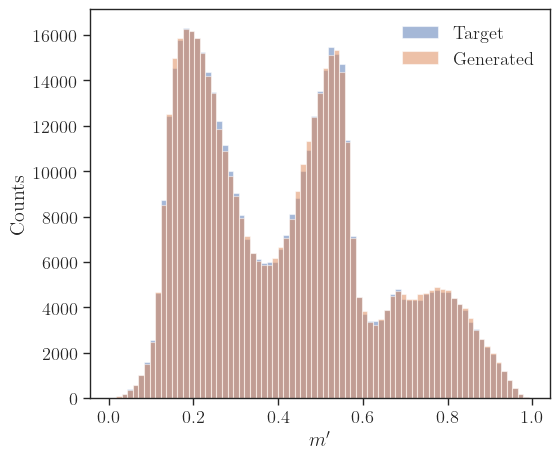

In [78]:
# Visualize 
fig, ax = plt.subplots(figsize=(6,5))

counts, bins, _ = ax.hist(mp_thetap[:N,0], 75, alpha = 0.5, label = r'$\mathrm{Target}$')
ax.hist(mp_thetap_gen[:,0], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$m'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_gen.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_gen.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

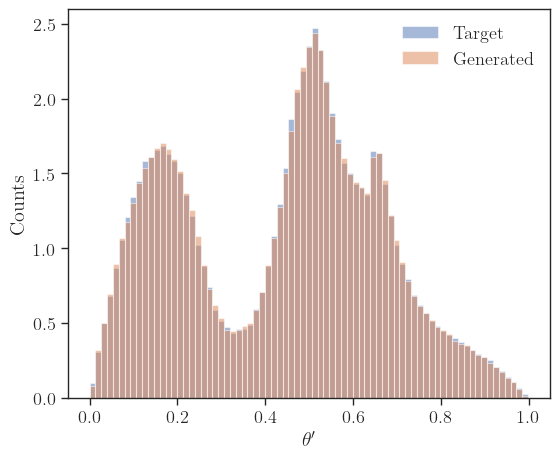

In [79]:
# Visualize 
fig, ax = plt.subplots(figsize=(6,5))

counts, bins, _ = ax.hist(mp_thetap[:N,1], 75, alpha = 0.5, label = r'$\mathrm{Target}$', density = True)
ax.hist(mp_thetap_gen[:,1], bins, alpha=0.5, label = r'$\mathrm{Generated}$', density = True)

ax.set_xlabel( r"$\theta'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )

#ax.text(0.6, 0.8, rf'$\texttt{{K}} = {K}$ \\ $\texttt{{N\_{{samples}}}} = {N}$ \\ $\texttt{{epochs}} = {epochs}$ \\ $\texttt{{N\_{{blocks}}}} = {n_blocks}$', transform=ax.transAxes, fontsize = 10)

ax.legend(loc='best', frameon=False)

fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_gen.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_gen.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

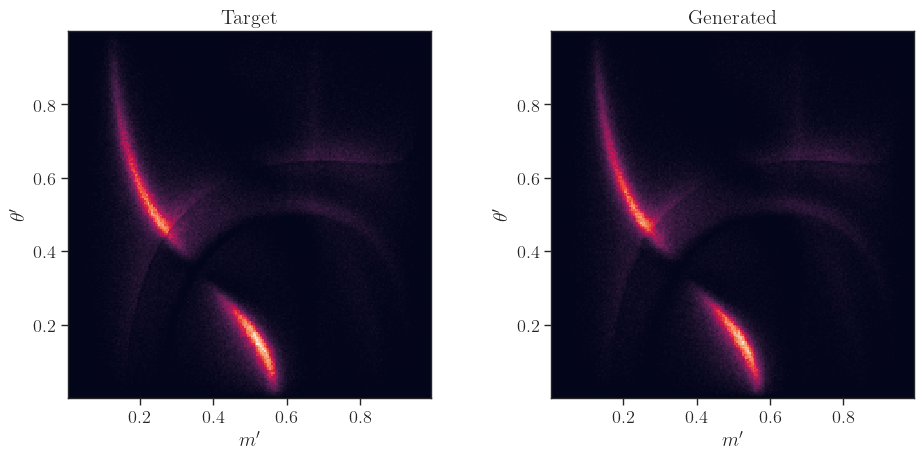

In [80]:
# Visualize 2D Dalitz plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5) )

h_sim, xedges, yedges, _ = ax1.hist2d(mp_thetap[:N,0], mp_thetap[:N,1], 200, rasterized=True)
h_gen, _, _, _ = ax2.hist2d(mp_thetap_gen[:,0], mp_thetap_gen[:,1], bins = [xedges, yedges], rasterized=True)

ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Target}$')
ax1.set_aspect('equal')

ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Generated}$')
ax2.set_aspect('equal')

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_INN_target_vs_gen.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_INN_target_vs_gen.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

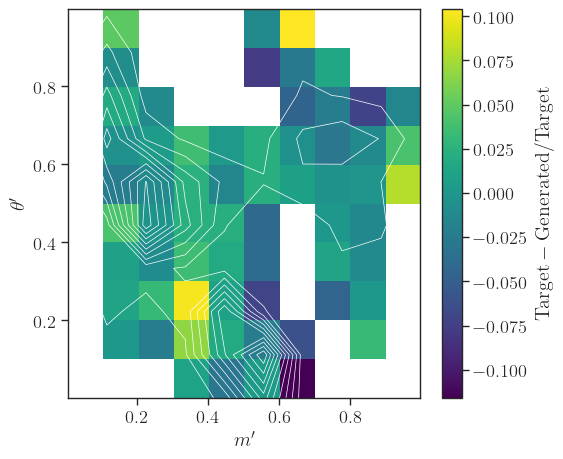

In [57]:
# Plot the per bin chi2 difference ignore bins with 0 entries
fig, ax = plt.subplots( figsize=(6,5) )
h_diff = (h_sim - h_gen) / h_sim
# Get rid of bins with counts less than 1000
h_diff[h_sim < 1000] = None
# Get rid of outliers
#h_diff[h_diff > 0.2] = 0.2
#h_diff[h_diff < -0.2] = -0.2
#h_diff = np.nan_to_num(h_diff)
im = ax.imshow(h_diff.T, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$\theta'$")
#ax.set_xlim(0, 0.4)
#ax.set_ylim(0.4, 0.5)
fig.colorbar(im, ax=ax, label = r'$\mathrm{Target - Generated / Target}$')
# Overlay a contour of the target distribution
ax.contour(h_sim.T, levels=10, colors='white', linewidths=0.5, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
fig.tight_layout()
fig.savefig(r'figs/D_amplitude_SDP_INN_per_bin_diff.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

In [67]:
# Save the model
torch.save(flow.state_dict(), 'INN_spline_D_to_Kpipi_square_Dalitz_amplitude_model5.pth')

In [ ]:
# Load the model

"""
--- MODEL 1 ---
# Hyperparameters
n_train = 2_000_000
n_batch = 25_000
epochs = 40
learning_rate = 0.001
min_learning_rate = 1e-6
n_blocks = 10
n_bins = 12
hidden_features = 100
# No LR scheduler
"""

#n_blocks = 10
#n_bins = 12
#N = 200_000

# Define the model
#flow = conjure_flow(num_flows = n_blocks, hidden_features = 100, num_bins = n_bins)

#flow.load_state_dict(torch.load('models/INN_spline_D_to_Kpipi_square_Dalitz_amplitude_model1.pth'))
#flow.eval()

"""
--- MODEL 2
# Hyperparameters
batch_size = 50000
epochs = 80
learning_rate = 0.005
min_learning_rate = 1e-6
n_blocks = 10
n_bins = 25
hidden_features = 128
ReduceLROnPlateau(opt, mode="min", factor=0.9, patience=2, min_lr=1e-6)
NLL loss minimum: ~ -1.24
"""

n_blocks = 10
n_bins = 25
hidden_features = 128
N = 200_000

# Print total number of parameters
flow = conjure_flow(num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)
total_params = sum(p.numel() for p in flow.parameters())
print(f"Total parameters: {total_params}")

# Define the model
flow = conjure_flow(num_flows = n_blocks, hidden_features = hidden_features, num_bins = n_bins)

flow.load_state_dict(torch.load('INN_spline_D_to_Kpipi_square_Dalitz_amplitude_model2.pth'))
flow.eval()

"""
--- MODEL 5 (The Champion)
# Hyperparameters
batch_size = 50000
epochs = 130
learning_rate_init = 0.009
patience = 3
factor = 0.9
min_learning_rate = 1e-6
n_blocks = 12
n_bins = 25
hidden_features = 128
ReduceLROnPlateau(opt, mode="min", factor=0.9, patience=3, min_lr=1e-6)
NLL loss minimum (at the end of training): -1.253 (-1.254 global minimum during training)
Total parameters: 315768
"""

Total parameters: 263140


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): InverseTransform(
        (_transform): Sigmoid()
      )
      (1): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=74, bias=True)
        )
      )
      (2): RandomPermutation()
      (3): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): MLP(
          (backbone): Sequential(
            (0): Linear(in_features=1, out_features=128, bias=True)
            (1): SiLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): SiLU()
          )
          (head): Linear(in_features=128, out_features=74, bias=True)
        )
      )
      (4): Rand

In [68]:
total_params = sum(p.numel() for p in flow.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 315768


In [33]:
@torch.no_grad()
def marginal_likelihood(flow, axis = 0, xs = None, nx = 400, ny = 800, 
                        on_unit_box = True, eps = 1e-8, data_range = None, 
                        batch = 65536, device = None):
    """
    Returns xs (np.ndarray of shape (nx,)) and log_likelihood_marginal (np.ndarray of shape (nx,))
    where log_likelihood_marginal[j] ~ log int p(x_axis = xs[j], other) d(other).

    flow: nflows.flows.Flow object
    axis: which axis to project out (0 or 1)
    xs: if provided, use these x values (np.ndarray of shape (nx,))
    nx: if xs is None, number of points along the projected axis
    ny: number of points along the marginalized axis
    on_unit_box: whether the flow was trained on [0,1]^2
    eps: if on_unit_box, avoid infinities by integrating over [eps, 1-eps]
    data_range: if not on_unit_box, the (min,max) for each axis; if None, uses [-3,3]
    batch: eval batch size for flow.log_prob
    device: torch device (default: "cuda" if available else "cpu")

    Returns:
    xs: np.ndarray of shape (nx,)
    log_marg: np.ndarray of shape (nx,)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    flow = flow.to(device).eval()

    # --- grids in DATA space ---
    if on_unit_box:
        xmin, xmax = eps, 1.0 - eps
        ymin, ymax = eps, 1.0 - eps
    else:
        if data_range is None:
            xmin, xmax = -3.0, 3.0
            ymin, ymax = -3.0, 3.0
        else:
            (xmin, xmax), (ymin, ymax) = data_range

    if xs is None:
        xs = np.linspace(xmin, xmax, nx, dtype=np.float32)
    else:
        xs = np.asarray(xs, dtype=np.float32)
        nx = xs.shape[0]

    ys = np.linspace(ymin, ymax, ny, dtype=np.float32)

    # Build full grid for evaluation: (ny * nx, 2)
    if axis == 0:
        XX = np.tile(xs, (ny, 1))                  # shape (ny, nx)
        YY = np.tile(ys[:, None], (1, nx))         # shape (ny, nx)
    else:
        XX = np.tile(ys[:, None], (1, nx))         # integrate over x if axis==1
        YY = np.tile(xs, (ny, 1))

    grid = np.stack([XX.ravel(), YY.ravel()], axis=1).astype(np.float32)
    grid_t = torch.from_numpy(grid).to(device)

    # Evaluate log p(x) on the grid (batched to be memory-safe)
    outs = []
    for i in range(0, grid_t.shape[0], batch):
        outs.append(flow.log_prob(grid_t[i:i+batch]))
    logp = torch.cat(outs, dim=0).view(ny, nx)     # reshape so axis 0 is the marginalized dim

    # Numerical integral: log ∫ p(x,y) dy ≈ logsumexp_y [ log p(x,y) ] + log Δy
    dy = (ymax - ymin) / (ny - 1)
    log_marg = torch.logsumexp(logp, dim=0) + torch.log(torch.tensor(dy, device=device))

    # CPU numpy outputs
    return xs, np.exp(log_marg.detach().cpu().numpy())

In [34]:
thetap, pthetap = marginal_likelihood(flow, axis=0, on_unit_box=True, nx=400, ny=1200, eps=1e-8)
mp, pmp = marginal_likelihood(flow, axis=1, on_unit_box=True, nx=400, ny=1200, eps=1e-8)

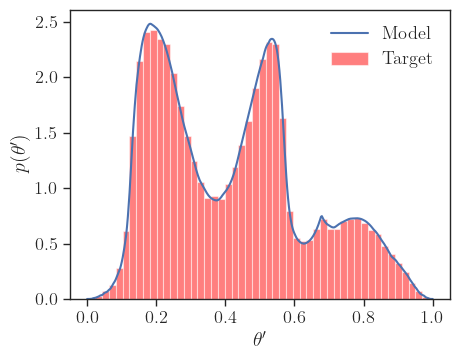

In [35]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

# Plot model likelihood
ax.plot(thetap, pthetap, lw=1.5, label = r'$\mathrm{Model}$')

# Plot the histograms for comparison
counts, bins, _ = ax.hist(mp_thetap[:N,0], 50, alpha = 0.5, label = r'$\mathrm{Target}$', density = True, color = 'red')

ax.legend(loc = 'best', frameon = False)
ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r'$p(\theta^\prime)$')
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

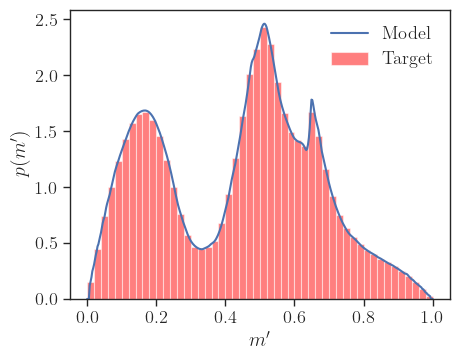

In [36]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(mp, pmp, lw=1.5, label = r'$\mathrm{Model}$')
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r'$p(m^\prime)$')

# Plot the histograms for comparison
counts, bins, _ = ax.hist(mp_thetap[:,1], 50, alpha = 0.5, label = r'$\mathrm{Target}$', density = True, color = 'red')
#ax.hist(mp_thetap_gen[:,1], bins, alpha=0.5, label = r'$\mathrm{Generated}$', density = True)
ax.legend(loc='best', frameon=False)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

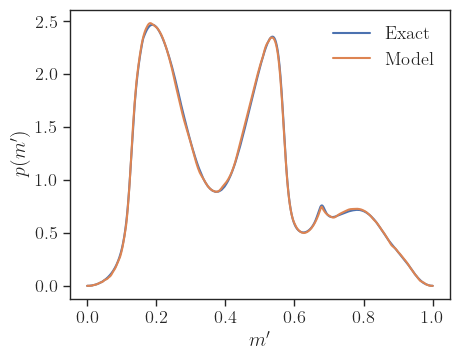

In [37]:
# Let's see if we can get the exact likelihood from the model that produced the training data
mprime_exact = np.load('../data/D_Kpipi_mprime.npy')
dens_m = np.load('../data/D_Kpipi_mprime_marginal.npy')

fig, ax = plt.subplots(1,1,figsize=(5,4))
# Plot model likelihood
ax.plot(mprime_exact, dens_m, lw=1.5, label = r'$\mathrm{Exact}$')
# Plot model likelihood
ax.plot(thetap, pthetap, lw=1.5, label = r'$\mathrm{Model}$')
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r'$p(m^\prime)$')
ax.legend(loc='best', frameon=False)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_exact_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_exact_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

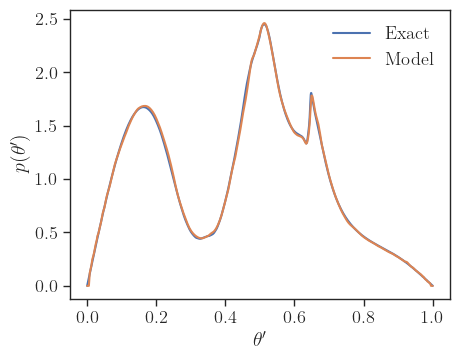

In [38]:
thetaprime_exact = np.load('../data/D_Kpipi_thetaprime.npy')
dens_thetaprime = np.load('../data/D_Kpipi_thetaprime_marginal.npy')

fig, ax = plt.subplots(1,1,figsize=(5,4))
# Plot model likelihood
ax.plot(thetaprime_exact, dens_thetaprime, lw=1.5, label = r'$\mathrm{Exact}$')
# Plot model likelihood
ax.plot(mp, pmp, lw=1.5, label = r'$\mathrm{Model}$')
ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r'$p(\theta^\prime)$')
ax.legend(loc='best', frameon=False)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_exact_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_exact_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

In [39]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../data_gen")))
from DKpp import DKpp

In [56]:
@torch.no_grad()
def conditional_pdf(
    flow,
    fixed_value,
    fixed_axis=0,         # 0 → fix x1=m', 1 → fix x2=θ'
    nx=400,
    on_unit_box=True,
    eps=1e-8,
    data_range=None,
    device=None,
):
    """
    Compute conditional density p(x_free | x_fixed=fixed_value).

    Returns:
        xs   (np.ndarray): grid values of the free variable
        pdf  (np.ndarray): normalized conditional density over xs
        logp (np.ndarray): unnormalized log joint for inspection
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    flow = flow.to(device).eval()

    # ranges
    if on_unit_box:
        xmin, xmax = eps, 1.0 - eps
        ymin, ymax = eps, 1.0 - eps
    else:
        if data_range is None:
            xmin, xmax = -3.0, 3.0
            ymin, ymax = -3.0, 3.0
        else:
            (xmin, xmax), (ymin, ymax) = data_range

    # grid over the free variable
    if fixed_axis == 0:
        xs = np.linspace(ymin, ymax, nx, dtype=np.float32)
        pts = np.stack([np.full_like(xs, fixed_value, dtype=np.float32), xs], axis=1)
    else:
        xs = np.linspace(xmin, xmax, nx, dtype=np.float32)
        pts = np.stack([xs, np.full_like(xs, fixed_value, dtype=np.float32)], axis=1)

    pts_t = torch.from_numpy(pts).to(device)

    # joint log-prob for each slice point
    logp = flow.log_prob(pts_t).cpu().numpy()
    pdf = np.exp(logp - logp.max())       # stabilize
    pdf /= np.trapezoid(pdf, xs)              # normalize to 1

    return xs, pdf, logp

/home/menzo/miniconda3/envs/ml_gamma_extraction/lib/python3.13/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


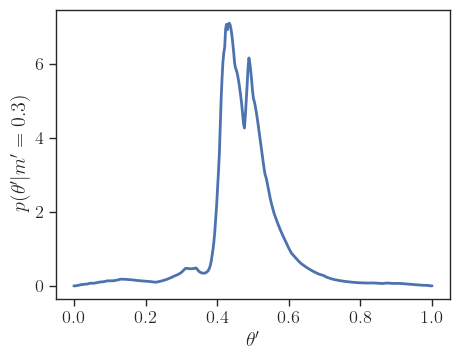

In [57]:
xs, pdf, logp = conditional_pdf(flow, fixed_value=0.3, fixed_axis=0,
                                nx=400, on_unit_box=True)

fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(xs, pdf, lw = 2)
ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r"$p(\theta' | m'=0.3)$")
fig.tight_layout()

In [58]:
# Map m' -> m12 and s12
def mprime_to_m12(mprime, mmin, mmax):
    """CLEO/BaBar/Belle convention: m'(0)=mmax, m'(1)=mmin."""
    dM = mmax - mmin
    return mmin + 0.5*dM*(1.0 + np.cos(np.pi*mprime))

# Map theta' -> s13 along the kinematic arc at fixed s12
def thetap_to_s13(thetap, s13min, s13max):
    # Now θ'=0 -> s13min, θ'=1 -> s13max (increasing order)
    return 0.5*(s13max + s13min) - 0.5*(s13max - s13min)*np.cos(np.pi*thetap)

# Full Jacobian |\partial(s12,s13)/\partial(m',\theta')|
def jacobian(mprime, thetap, mmin, mmax, s13min, s13max):
    m12  = mprime_to_m12(mprime, mmin, mmax)
    dM   = (mmax - mmin)
    ds12_dmp  = -np.pi * dM * m12 * np.sin(np.pi*mprime)              # magnitude will be taken
    ds13_dthp = -0.5*np.pi * (s13max - s13min) * np.sin(np.pi*thetap) # magnitude will be taken
    return np.abs(ds12_dmp) * np.abs(ds13_dthp)

# Kallen function
def kallen(x,y,z):
    return x*x + y*y + z*z - 2*(x*y + x*z + y*z)

# Generic limits: given sij, return sik^{min,max}
# PDG three-body kinematics (M = parent mass, mi = masses of i,j,k)
def sik_limits_given_sij(sij, M, mi, mj, mk):
    M2 = M*M
    mi2, mj2, mk2 = mi*mi, mj*mj, mk*mk
    s = np.asarray(sij)
    # central term
    num = (s + mi2 - mj2)*(M2 - s - mk2)
    # phase-space term
    root = np.sqrt(np.maximum(kallen(s, mi2, mj2) * kallen(M2, s, mk2), 0.0))
    den = 2*s
    sik_max = mi2 + mk2 + (num + root)/den
    sik_min = mi2 + mk2 + (num - root)/den
    return sik_min, sik_max

In [59]:
def abs_ds13_dthetap(thetap, s13min, s13max):
    # |∂s13/∂θ'| for the square-Dalitz mapping
    return 0.5*np.pi*(s13max - s13min)*np.abs(np.sin(np.pi*thetap))

def abs_ds12_dmprime(mprime, mmin, mmax):
    # |∂s12/∂m'|
    m12 = mprime_to_m12(mprime, mmin, mmax)
    dM  = (mmax - mmin)
    return np.pi * dM * m12 * np.abs(np.sin(np.pi*mprime))

In [60]:
def conditional_theta_given_mprime(amp_obj, mprime, n_theta=400):
    """
    Returns (thetap_grid, pdf_theta), normalized so that ∫_0^1 pdf(θ'|m') dθ' = 1.
    """
    M  = amp_obj.M()
    m1, m2, m3 = amp_obj.m1(), amp_obj.m2(), amp_obj.m3()
    mmin = m1 + m2
    mmax = M  - m3

    # fixed s12 from m'
    m12 = mprime_to_m12(mprime, mmin, mmax)
    s12 = m12*m12

    # θ' grid (uniform is fine; we include the Jacobian below)
    thetap = np.linspace(0.0, 1.0, n_theta)

    # kinematic limits and map θ' -> s13(θ')
    s13min, s13max = sik_limits_given_sij(s12, M, m1, m2, m3)
    s13 = thetap_to_s13(thetap, s13min, s13max)

    # evaluate |A|^2 on the slice (m' fixed, θ' varying)
    pts = np.column_stack([np.full_like(s13, s12), s13])
    A = amp_obj.full(pts)
    mod2 = (A.real*A.real + A.imag*A.imag)

    # Conditional density ∝ |A|^2 * |∂s13/∂θ'|
    dens = mod2 * abs_ds13_dthetap(thetap, s13min, s13max)

    # normalize to unit area over θ'
    area = np.trapezoid(dens, thetap)
    pdf  = dens / (area + 1e-300)
    return thetap, pdf

# ================================================================
# p(m' | θ'): conditional PDF of m' at fixed θ'  (slice in m')
# ================================================================
def conditional_mprime_given_theta(amp_obj, thetap, n_mprime=400):
    """
    Returns (mprime_grid, pdf_mprime), normalized so that ∫_0^1 pdf(m'|θ') dm' = 1.
    """
    M  = amp_obj.M()
    m1, m2, m3 = amp_obj.m1(), amp_obj.m2(), amp_obj.m3()
    mmin = m1 + m2
    mmax = M  - m3

    # m' grid (uniform; include |∂s12/∂m'| Jacobian below)
    mprime = np.linspace(0.0, 1.0, n_mprime)

    # for each m', build s12(m') and s13(θ' ; s12)
    m12 = mprime_to_m12(mprime, mmin, mmax)
    s12 = m12*m12
    s13min, s13max = sik_limits_given_sij(s12, M, m1, m2, m3)  # vectorized over m'
    s13 = thetap_to_s13(thetap, s13min, s13max)

    pts = np.column_stack([s12, s13])
    A = amp_obj.full(pts)
    mod2 = (A.real*A.real + A.imag*A.imag)

    # Conditional density ∝ |A|^2 * |∂s12/∂m'|
    dens = mod2 * abs_ds12_dmprime(mprime, mmin, mmax)

    # normalize to unit area over m'
    area = np.trapezoid(dens, mprime)
    pdf  = dens / (area + 1e-300)
    return mprime, pdf

In [61]:
dk = DKpp()

# Slice at fixed m' (e.g., m' = 0.35)
thp, p_th_given_m = conditional_theta_given_mprime(dk, mprime=0.3, n_theta=600)

# Slice at fixed θ' (e.g., θ' = 0.60)
mp, p_m_given_th = conditional_mprime_given_theta(dk, thetap=0.20, n_mprime=600)

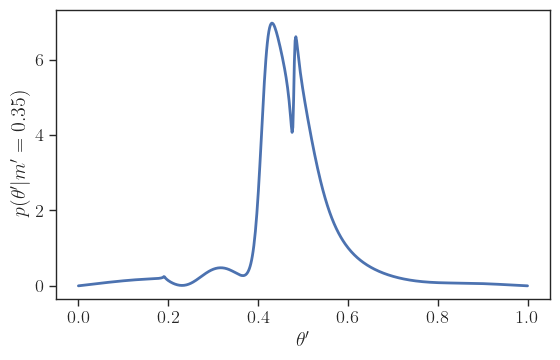

In [62]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(thp, p_th_given_m, lw=2)
ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r"$p(\theta'|m'=0.35)$")
fig.tight_layout()

/home/menzo/miniconda3/envs/ml_gamma_extraction/lib/python3.13/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


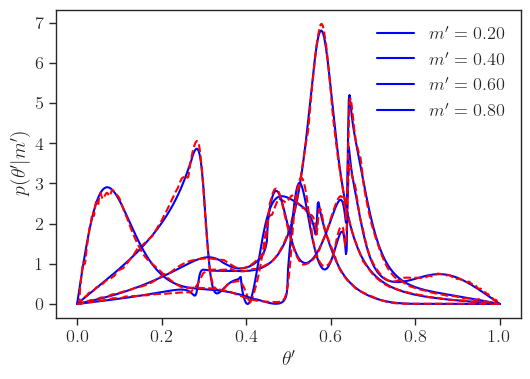

In [72]:
# Define a set of m' slices
mprime_slices = np.linspace(0.2, 0.8, 4)

fig, ax = plt.subplots(1,1,figsize=(6,4))
for mprime in mprime_slices:
    # Compute the exact conditional
    thp, p_th_given_m = conditional_theta_given_mprime(dk, mprime=mprime, n_theta=600)
    ax.plot(thp, p_th_given_m, lw=1.5, label = rf'$m^\prime = {mprime:.2f}$', color = 'blue')

    # Compute the model conditional
    xs, pdf, logp = conditional_pdf(flow, fixed_value=mprime, fixed_axis=0,
                                    nx=400, on_unit_box=True)
    ax.plot(xs, pdf, '--', lw=1.5, color = 'red')

ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r"$p(\theta'|m')$")
ax.legend(loc='best', frameon=False)
#fig.tight_layout()

/home/menzo/miniconda3/envs/ml_gamma_extraction/lib/python3.13/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


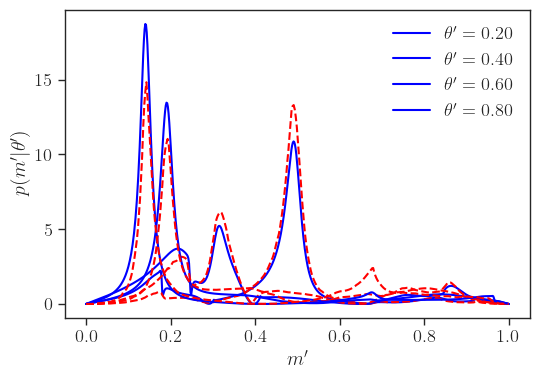

In [71]:
thetap_slices = np.linspace(0.2, 0.8, 4)

fig, ax = plt.subplots(1,1,figsize=(6,4))
for thetap in thetap_slices:
    # Compute the exact conditional
    mp, p_m_given_th = conditional_mprime_given_theta(dk, thetap=thetap, n_mprime=600)
    ax.plot(mp, p_m_given_th, lw=1.5, label = rf'$\theta^\prime = {thetap:.2f}$', color = 'blue')

    # Compute the model conditional
    xs, pdf, logp = conditional_pdf(flow, fixed_value=thetap, fixed_axis=1,
                                    nx=400, on_unit_box=True)
    ax.plot(xs, pdf, '--', lw=1.5, color = 'red')

ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$p(m'|\theta')$")
ax.legend(loc='best', frameon=False)

/home/menzo/miniconda3/envs/ml_gamma_extraction/lib/python3.13/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


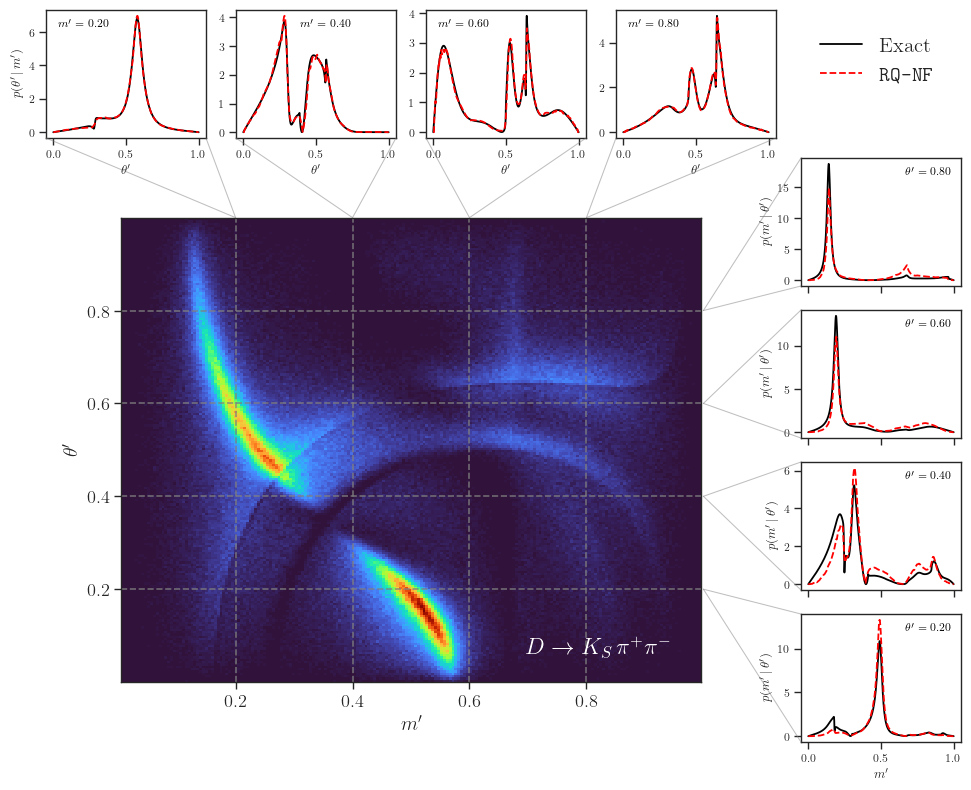

In [240]:
# Manual placement: large top/right subplots that can extend beyond the main panel.
# - You add your own plotting to ax_main, top_axes[i], right_axes[j].
# - Adjust only the "LAYOUT PARAMETERS" block to resize/space everything.

from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

# --------------------------
# LAYOUT PARAMETERS (tweak these)
# --------------------------
n_top    = 4   # number of top subplots
n_right  = 4   # number of right subplots

# Main panel position [left, bottom, width, height] in figure fractions
MAIN = [0.12, 0.12, 0.58, 0.58]

# Top-strip geometry (subplots are placed manually above MAIN)
TOP_HEIGHT   = 0.16      # height of each top subplot
TOP_BOX_W    = 0.16      # width of each top subplot
TOP_GAP_W    = 0.03      # horizontal gap between top subplots
TOP_GAP_ABOVE= 0.1      # vertical gap between MAIN top and the bottom of the top strip

# Right-strip geometry (subplots placed manually to the right of MAIN)
RIGHT_WIDTH  = 0.16      # width of each right subplot
RIGHT_BOX_H  = 0.16      # height of each right subplot
RIGHT_GAP_H  = 0.03      # vertical gap between right subplots
RIGHT_GAP_SIDE=0.1      # horizontal gap between MAIN right and the left of the right strip

# Data limits for the main panel (used for connectors only)
m_lim     = (0.0, 1.0)   # x-range (m')
theta_lim = (0.0, 1.0)   # y-range (theta')

# Bands for conditionals (edit/replace with custom edges as needed)
m_edges     = np.linspace(m_lim[0],     m_lim[1],     n_top   + 1)  # vertical bands (for TOP)
theta_edges = np.linspace(theta_lim[0], theta_lim[1], n_right + 1)  # horizontal bands (for RIGHT)

# --------------------------
# BUILD FIGURE + AXES (manual positions)
# --------------------------
fig = plt.figure(figsize=(10, 8))

# Main axis
ax_main = fig.add_axes(MAIN)
ax_main.set_xlim(*m_lim)
ax_main.set_ylim(*theta_lim)
ax_main.set_xlabel(r"$m^\prime$")
ax_main.set_ylabel(r"$\theta^\prime$")
h_sim, xedges, yedges, _ = ax_main.hist2d(mp_thetap[:N,0], mp_thetap[:N,1], 200, rasterized=True, cmap='turbo')
ax_main.text(0.95, 0.05, r'$D \to K_S\,\pi^+ \pi^-$', transform=ax_main.transAxes,
             fontsize=17, color='white', ha='right', va='bottom', weight='bold')

# Place horizontal and vertical dashed lines corresponding to conditionals in top and right subplots
for mp in mprime_slices:
    ax_main.axvline(mp, ls='--', color='gray', lw=1.2, alpha=0.8)
for thp in thetap_slices:
    ax_main.axhline(thp, ls='--', color='gray', lw=1.2, alpha=0.8)

# Compute the horizontal span available above MAIN and center the top strip in that span
main_left, main_bottom, main_w, main_h = MAIN
top_y = main_bottom + main_h + TOP_GAP_ABOVE
top_span_left  = main_left
top_span_right = main_left + main_w
total_top_width = n_top*TOP_BOX_W + (n_top-1)*TOP_GAP_W
top_left0 = top_span_left + 0.5*(main_w - total_top_width)  # center over MAIN

top_axes = []
for i in range(n_top):
    left = top_left0 + i*(TOP_BOX_W + TOP_GAP_W)
    ax = fig.add_axes([left, top_y, TOP_BOX_W, TOP_HEIGHT])
    # Typical usage: ax.set_xlim(theta_lim); ax.plot(theta, p_theta_given_m_band)
    ax.tick_params(labelsize=8)
    if i > 0:
        #ax.set_yticklabels([])
        ax.set_xlabel(r"$\theta^\prime$", fontsize=9)
    if i == 0:
        ax.set_ylabel(r"$p(\theta^\prime\,|\,m^\prime)$", fontsize=9)
        ax.set_xlabel(r"$\theta^\prime$", fontsize=9)
    top_axes.append(ax)

# Compute the vertical span available to the right of MAIN and center the right strip in that span
right_x = main_left + main_w + RIGHT_GAP_SIDE
right_span_bottom = main_bottom
right_span_top    = main_bottom + main_h
total_right_height = n_right*RIGHT_BOX_H + (n_right-1)*RIGHT_GAP_H
right_bottom0 = right_span_bottom + 0.5*(main_h - total_right_height)

right_axes = []
for j in range(n_right):
    bottom = right_bottom0 + (n_right-1-j)*(RIGHT_BOX_H + RIGHT_GAP_H)  # top-to-bottom order
    ax = fig.add_axes([right_x, bottom, RIGHT_WIDTH, RIGHT_BOX_H])
    # Typical usage: ax.set_ylim(m_lim); ax.plot(p_m_given_theta_band, m)
    ax.tick_params(labelsize=8)
    if j < n_right - 1:
        ax.set_xticklabels([])
        ax.set_ylabel(r"$p(m^\prime\,|\,\theta^\prime)$", fontsize=9)
    else:
        ax.set_xlabel(r"$m^\prime$", fontsize=9)
        ax.set_ylabel(r"$p(m^\prime\,|\,\theta^\prime)$", fontsize=9)

    right_axes.append(ax)

for j, ax in enumerate(right_axes):
    # Compute the exact conditional
    mp, p_m_given_th = conditional_mprime_given_theta(dk, thetap=thetap_slices[-(j+1)], n_mprime=600)
    ax.plot(mp, p_m_given_th, lw=1.3, label = rf'$\theta^\prime = {thetap_slices[-(j+1)]:.2f}$', color = 'black')

    # Compute the model conditional
    xs, pdf, logp = conditional_pdf(flow, fixed_value=thetap_slices[-(j+1)], fixed_axis=1,
                                    nx=400, on_unit_box=True)
    ax.plot(xs, pdf, '--', lw=1.3, color = 'red')
    ax.text(0.65, 0.93, rf'$\theta^\prime = {thetap_slices[-(j+1)]:.2f}$', transform=ax.transAxes,
            fontsize=8, color='black', ha='left', va='top')
    #ax.legend(loc='best', fontsize=6, frameon=False)

for j, ax in enumerate(top_axes):
    # Compute the exact conditional
    thp, p_th_given_m = conditional_theta_given_mprime(dk, mprime=mprime_slices[j], n_theta=600)
    ax.plot(thp, p_th_given_m, lw=1.3, label = rf'$m^\prime = {mprime_slices[j]:.2f}$', color = 'black')

    # Compute the model conditional
    xs, pdf, logp = conditional_pdf(flow, fixed_value=mprime_slices[j], fixed_axis=0,
                                    nx=400, on_unit_box=True)
    ax.plot(xs, pdf, '--', lw=1.3, color = 'red')
    if j != 1:
        ax.text(0.075, 0.93, rf'$m^\prime = {mprime_slices[j]:.2f}$', transform=ax.transAxes,
                fontsize=8, color='black', ha='left', va='top')
    else: 
        ax.text(0.4, 0.93, rf'$m^\prime = {mprime_slices[j]:.2f}$', transform=ax.transAxes,
                fontsize=8, color='black', ha='left', va='top')

# --- two connectors from EACH vertical slice to BOTH bottom corners of its corresponding top subplot ---
n_top_use = min(len(mprime_slices), len(top_axes))
for i in range(n_top_use):
    xA = float(mprime_slices[i])
    ax_top = top_axes[i]
    for x_frac in (0.0, 1.0):  # bottom-left and bottom-right corners
        cp = ConnectionPatch(
            xyA=(xA, theta_lim[1]),      coordsA=ax_main.transData,   axesA=ax_main,
            xyB=(x_frac, 0.0),           coordsB=ax_top.transAxes,    axesB=ax_top,
            color='gray', lw=0.75, alpha=0.5, zorder=1000, clip_on=False
        )
        fig.add_artist(cp)

# --- two connectors from EACH horizontal slice to BOTH left corners of its corresponding right subplot ---
n_right_use = min(len(thetap_slices), len(right_axes))
for j in range(n_right_use):
    # pair the *topmost* horizontal slice with the *topmost* right subplot
    yA = float(thetap_slices[j])
    ax_right = right_axes[-(j+1)]   # reverse the mapping: top slice -> top subplot
    for y_frac in (0.0, 1.0):  # left-bottom and left-top corners
        cp = ConnectionPatch(
            xyA=(m_lim[1], yA),           coordsA=ax_main.transData,  axesA=ax_main,
            xyB=(0.0, y_frac),            coordsB=ax_right.transAxes, axesB=ax_right,
            color='gray', lw=0.75, alpha=0.5, zorder=1000, clip_on=False
        )
        fig.add_artist(cp)

# Add custom legend for top/right subplots
custom_lines = [Line2D([0], [0], color='black', lw=1.3, ls='-'),
                Line2D([0], [0], color='red', lw=1.3, ls='--')]
fig.legend(custom_lines, [r'$\mathrm{Exact}$', r'$\texttt{RQ-NF}$'], 
           loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=15, frameon=False)

#fig.tight_layout()
fig.savefig(r'figs/D_Kpipi_amplitude_SDP_RQ_NF_conditionals.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
fig.savefig(r'figs/D_Kpipi_amplitude_SDP_RQ_NF_conditionals.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

In [ ]:
# Visualize 2D Dalitz plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5) )

h_sim, xedges, yedges, _ = ax1.hist2d(mp_thetap[:N,0], mp_thetap[:N,1], 200, rasterized=True)
h_gen, _, _, _ = ax2.hist2d(mp_thetap_gen[:,0], mp_thetap_gen[:,1], bins = [xedges, yedges], rasterized=True)

ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Target}$')
ax1.set_aspect('equal')

ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Generated}$')
ax2.set_aspect('equal')

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_INN_target_vs_gen.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_INN_target_vs_gen.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

In [242]:
thetap, pthetap = marginal_likelihood(flow, axis=0, on_unit_box=True, nx=400, ny=1200, eps=1e-8)
mp, pmp = marginal_likelihood(flow, axis=1, on_unit_box=True, nx=400, ny=1200, eps=1e-8)

(np.float64(-0.1230841875076294),
 np.float64(2.5847679376602173),
 np.float64(0.00012155804273503196),
 np.float64(0.9987097842826473))

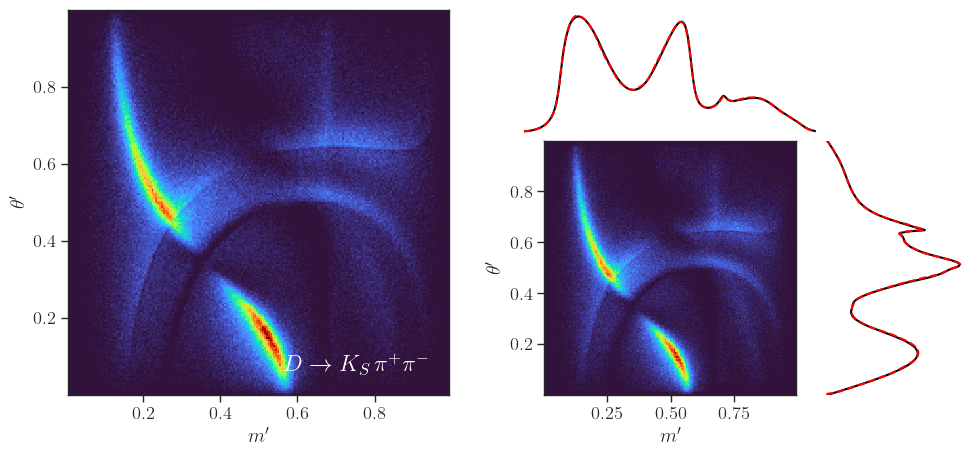

In [219]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# --- Figure layout: 2 panels side-by-side ---
fig = plt.figure(figsize=(12, 5))
outer_gs = GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

# ----------------- LEFT PANEL (Target) -----------------
ax_joint_L = fig.add_subplot(outer_gs[0])
h_sim, xedges, yedges, _ = ax_joint_L.hist2d(
    mp_thetap[:N, 0], mp_thetap[:N, 1], 200, rasterized=True, cmap='turbo')
ax_joint_L.set_xlabel(r"$m'$")
ax_joint_L.set_ylabel(r"$\theta'$")
ax_joint_L.set_aspect('equal')
ax_joint_L.text(0.95, 0.05, r'$D \to K_S\,\pi^+ \pi^-$', transform=ax_joint_L.transAxes,
             fontsize=17, color='white', ha='right', va='bottom', weight='bold')
#ax_joint_L.set_xlim(0,1)
#ax_joint_L.set_ylim(0,1)

# ----------------- RIGHT PANEL (Generated with marginals) -----------------
gs_right = GridSpecFromSubplotSpec(
    2, 2, subplot_spec=outer_gs[1],
    width_ratios=[2, 1], height_ratios=[1, 2],
    wspace=0.02, hspace=0.02
)
ax_joint_R = fig.add_subplot(gs_right[1, 0])
ax_top_R   = fig.add_subplot(gs_right[0, 0], sharex=ax_joint_R)
ax_right_R = fig.add_subplot(gs_right[1, 1], sharey=ax_joint_R)

# Joint histogram (Generated) — reuse edges for consistent binning
h_gen, _, _, _ = ax_joint_R.hist2d(
    mp_thetap_gen[:, 0], mp_thetap_gen[:, 1],
    bins=[xedges, yedges], rasterized=True, cmap='turbo')
ax_joint_R.set_xlabel(r"$m'$")
ax_joint_R.set_ylabel(r"$\theta'$")
ax_joint_R.set_aspect('equal')

# Top marginal curves (m′ density)
ax_top_R.plot(mprime_exact, dens_m, lw=1.5, label=r'$\mathrm{Exact}$', color = 'black')
ax_top_R.plot(thetap, pthetap, '--', lw=1.5, label=r'$\mathrm{Model}$', color = 'red')
ax_top_R.axis("off")

# Right marginal curves (θ′ density)
ax_right_R.plot(dens_thetaprime, thetaprime_exact, lw=1.5, label=r'$\mathrm{Exact}$', color = 'black')
ax_right_R.plot(pmp, mp, '--', lw=1.5, label=r'$\mathrm{Model}$', color = 'red')
ax_right_R.axis("off")


<>:115: SyntaxWarning: invalid escape sequence '\m'
<>:115: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_148835/873711482.py:115: SyntaxWarning: invalid escape sequence '\m'
  ax_top_R.plot(mprime_exact, dens_m, lw=1.5, color='black', label=r'$\mathrm{Exact}$')


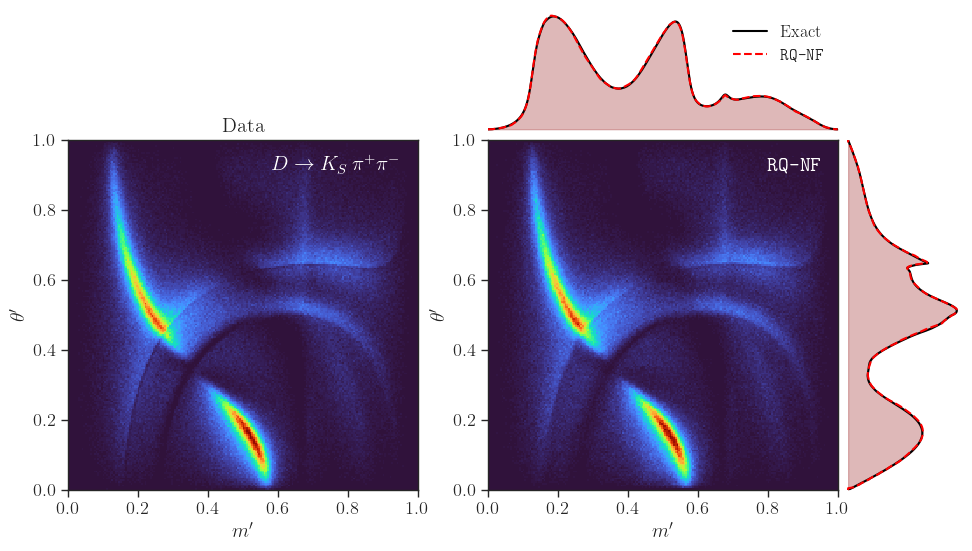

In [273]:
# --- Named variables for layout ---
LEFT_START   = 0.08   # x-position of left panel
BOTTOM       = 0.12   # y-position (shared by both)
MAIN_WIDTH   = 0.32   # width of each main subplot
MAIN_HEIGHT  = 0.70   # height of each main subplot
MAIN_GAP     = 0.03   # horizontal gap between left and right mains
MARGINAL_GAP = 0.01   # gap between main and marginal axes
TOP_HEIGHT   = 0.25   # height of top marginal
RIGHT_WIDTH  = 0.10   # width of right marginal

# --- Build main panel positions ---
LM = [LEFT_START, BOTTOM, MAIN_WIDTH, MAIN_HEIGHT]
RM = [LEFT_START + MAIN_WIDTH + MAIN_GAP, BOTTOM, MAIN_WIDTH, MAIN_HEIGHT]

# --- Marginal positions for the right panel ---
RTOP   = [RM[0], RM[1] + RM[3] + MARGINAL_GAP, RM[2], TOP_HEIGHT]
RRIGHT = [RM[0] + RM[2] + MARGINAL_GAP - 0.02, RM[1], RIGHT_WIDTH, RM[3]]

# ----------------- LEFT MAIN (Target) -----------------
fig = plt.figure(figsize=(12, 5))
ax_joint_L = fig.add_axes(LM)
h_sim, xedges, yedges, _ = ax_joint_L.hist2d(mp_thetap[:N, 0], mp_thetap[:N, 1], bins = [np.linspace(0, 1, 201), np.linspace(0, 1, 201)], rasterized=True, cmap='turbo')
ax_joint_L.set_xlabel(r"$m'$")
ax_joint_L.set_ylabel(r"$\theta'$")
ax_joint_L.set_aspect('equal')
ax_joint_L.text(0.95, 0.9, r'$D \to K_S\,\pi^+ \pi^-$', transform=ax_joint_L.transAxes,
                fontsize=15, color='white', ha='right', va='bottom', weight='bold')
ax_joint_L.set_title(r'$\mathrm{Data}$')

# ----------------- RIGHT MAIN + MARGINALS (Generated) -----------------
ax_joint_R = fig.add_axes(RM)
h_gen, _, _, _ = ax_joint_R.hist2d(mp_thetap_gen[:, 0], mp_thetap_gen[:, 1], bins=[xedges, yedges], rasterized=True, cmap='turbo')

ax_joint_R.set_xlabel(r"$m'$")
ax_joint_R.set_ylabel(r"$\theta'$")
ax_joint_R.set_aspect('equal')
ax_joint_R.text(0.95, 0.9, r'$\texttt{RQ-NF}$', transform=ax_joint_R.transAxes,
                fontsize=15, color='white', ha='right', va='bottom', weight='bold')

# After ax_joint_R is created and set_aspect('equal') is called:
# 1) Create marginals
ax_top_R   = fig.add_axes(RTOP)
ax_right_R = fig.add_axes(RRIGHT)

# 2) Make the TOP marginal exactly match the rendered left/width of ax_joint_R
#    (aspect='equal' may shrink/expand the joint's actual width)
left, bottom, width, height = ax_joint_R.get_position().bounds
top_left   = left
top_bottom = RTOP[1]
top_width  = width
top_height = RTOP[3]
ax_top_R.set_position([top_left, top_bottom, top_width, top_height])

# 3) Lock limits to the 2D hist range (prevents autoscale drift)
xmin, xmax = xedges[0], xedges[-1]
ymin, ymax = yedges[0], yedges[-1]
ax_joint_R.set_xlim(xmin, xmax)
ax_joint_R.set_ylim(ymin, ymax)

ax_top_R.set_xlim(xmin, xmax)
ax_top_R.set_autoscalex_on(False)
ax_top_R.margins(x=0)

ax_right_R.set_ylim(ymin, ymax)
ax_right_R.set_autoscaley_on(False)
ax_right_R.margins(y=0)


# assume xmin,xmax,ymin,ymax already set; limits locked; positions adjusted

# ---- TOP marginal (fill under m′ density) ----
mask_exact_x = (mprime_exact >= xmin) & (mprime_exact <= xmax)
mask_model_x = (thetap       >= xmin) & (thetap       <= xmax)

ax_top_R.fill_between(mprime_exact[mask_exact_x],
                      dens_m[mask_exact_x],
                      0, color='black', alpha=0.15, zorder=1)
ax_top_R.plot(mprime_exact[mask_exact_x],
              dens_m[mask_exact_x], color='black', lw=1.5, zorder=2, label=r'$\mathrm{Exact}$')

ax_top_R.fill_between(thetap[mask_model_x],
                      pthetap[mask_model_x],
                      0, color='red', alpha=0.15, zorder=1)
ax_top_R.plot(thetap[mask_model_x],
              pthetap[mask_model_x], '--', color='red', lw=1.5, zorder=2, label=r'$\texttt{RQ-NF}$')

# keep top marginal clean
ax_top_R.set_xlim(xmin, xmax)
ax_top_R.axis('off')
ax_top_R.legend(loc='upper right', fontsize=12, frameon=False)

# ---- RIGHT marginal (fill under θ′ density; horizontal) ----
mask_exact_y = (thetaprime_exact >= ymin) & (thetaprime_exact <= ymax)
mask_model_y = (mp               >= ymin) & (mp               <= ymax)

ax_right_R.fill_betweenx(thetaprime_exact[mask_exact_y],
                         0, dens_thetaprime[mask_exact_y],
                         color='black', alpha=0.15, zorder=1)
ax_right_R.plot(dens_thetaprime[mask_exact_y],
                thetaprime_exact[mask_exact_y], color='black', lw=1.5, zorder=2)

ax_right_R.fill_betweenx(mp[mask_model_y],
                         0, pmp[mask_model_y],
                         color='red', alpha=0.15, zorder=1)
ax_right_R.plot(pmp[mask_model_y],
                mp[mask_model_y], '--', color='red', lw=1.5, zorder=2)

# keep right marginal clean
ax_right_R.set_ylim(ymin, ymax)
ax_right_R.axis('off')

"""
# Top marginal
#ax_top_R = fig.add_axes(RTOP, sharex=ax_joint_R)
ax_top_R.plot(mprime_exact, dens_m, lw=1.5, color='black', label=r'$\mathrm{Exact}$')
ax_top_R.plot(thetap, pthetap, '--', lw=1.5, color='red', label=r'$\texttt{RQ-\,NF}$')
#ax_top_R.set_xlim(ax_joint_R.get_xlim())
ax_top_R.set_xlim(0,1)
ax_top_R.legend(loc='upper right', fontsize=12, frameon=False)
ax_top_R.axis("off")

# Right marginal
#ax_right_R = fig.add_axes(RRIGHT, sharey=ax_joint_R)
ax_right_R.plot(dens_thetaprime, thetaprime_exact, lw=1.5, color='black', label=r'$\mathrm{Exact}$')
ax_right_R.plot(pmp, mp, '--', lw=1.5, color='red', label=r'$\mathrm{Model}$')
ax_right_R.set_ylim(ax_joint_R.get_ylim())
ax_right_R.axis("off")
"""

fig.savefig(r'figs/D_Kpipi_amplitude_SDP_RQ_NF_marginals.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
fig.savefig(r'figs/D_Kpipi_amplitude_SDP_RQ_NF_marginals.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')